In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from glob import glob

cmap_tab = plt.get_cmap('tab10')
cmap_seq = plt.get_cmap('viridis')
cmap_blue = plt.get_cmap('Blues')

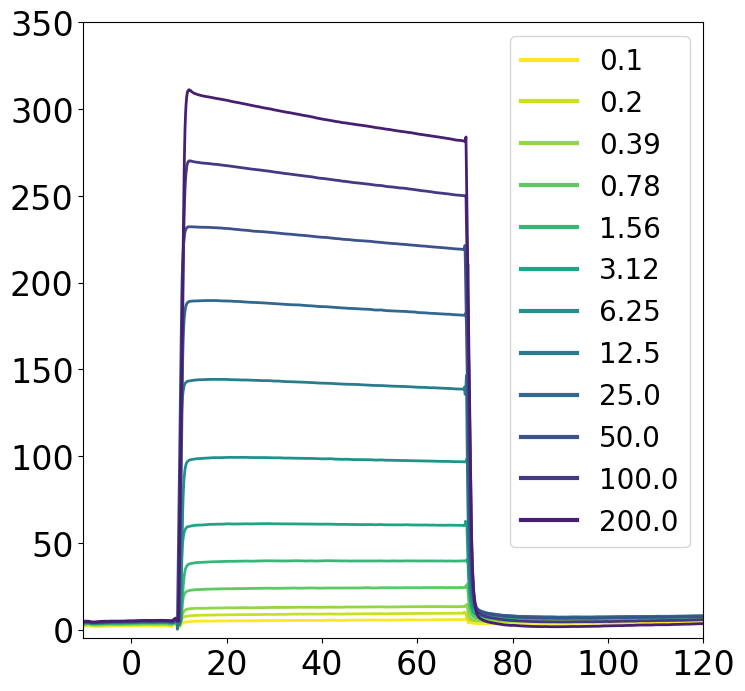

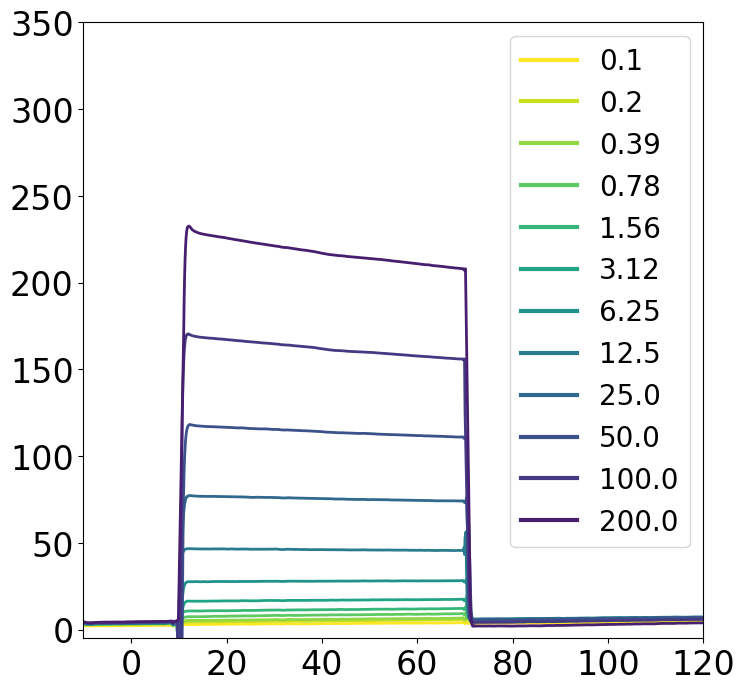

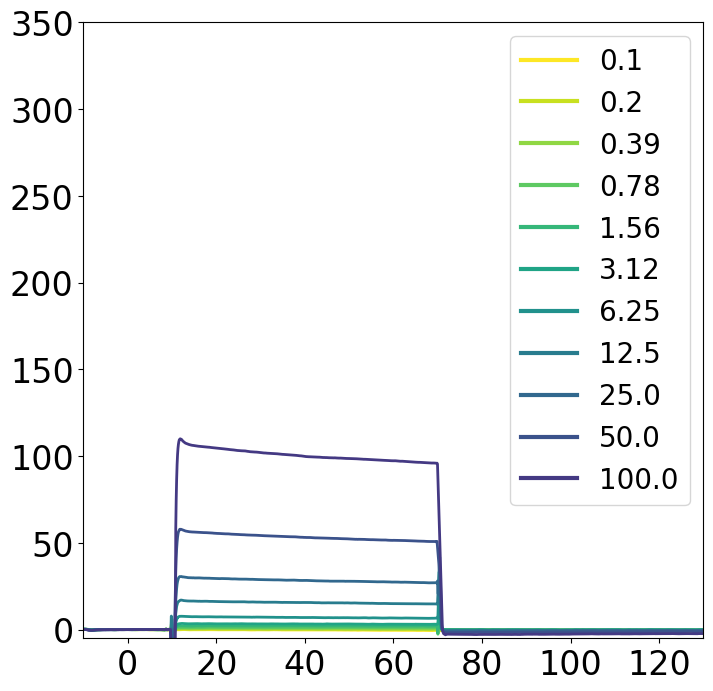

In [31]:
x_scale = 1e6

colors = {}
for pep in ['gp33','PF','Y4F']:
    colors[pep] = {}
    
    plt.figure(figsize=[8,8])

    sensogram = pd.read_csv(glob('../figure2_H2Db-characterization-xtal/SPR raw data on smartMHC/202210 SPR wwDb/'+\
                            f'* wwDb {pep} sensogram.txt')[0],
                            sep='\t')
    if pep == 'Y4F':
        for col in sensogram.columns:
            sensogram[col] = sensogram[col].astype(str).map(lambda x: float(x.replace(',','.')))
    
    data_eq = pd.read_csv(glob(f'../figure2_H2Db-characterization-xtal/SPR raw data on smartMHC/202210 SPR wwDb/* wwDb {pep}.txt')[0],
                          sep='\t')
    data_eq = data_eq[~np.isnan(data_eq['X'])]

    if pep == 'Y4F':
        x_low = -10
        x_high = 120
    else:
        x_col = 'Cycle=16_Fc=2-1_X'
        y_col = 'Cycle=16_Fc=2-1_Y'
        win_min = 500
        win_max = 600
    
        sensogram_subset = sensogram[(sensogram[x_col] > win_min) & (sensogram[x_col] < win_max)]    
        diff = sensogram_subset[y_col].values[1:] - sensogram_subset[y_col].values[:-1]
        is_max = diff == np.max(diff)
        is_max = np.concatenate([is_max,[False]],axis=0)
        
        x_low = sensogram_subset.loc[is_max,'Cycle=16_Fc=2-1_X'].values[0] - 10
        x_high = x_low + 120

    last_label = ''
    offset = 0
    if pep == 'Y4F':
        start = 18
        end = 32
    else:
        start = 2
        end = 17
        
    for c in range(start,end):

        label = round(data_eq["X"][c-start]*x_scale,2)

        if label==last_label:
            offset += 1
            continue

        if pep == 'Y4F':
            x_col = f'Cycle: {c}  gp33 Y4F  {round(data_eq["X"][c-start]*1e9)} nM_X'
            y_col = f'Cycle: {c}  gp33 Y4F  {round(data_eq["X"][c-start]*1e9)} nM_Y'
        else:
            x_col = f'Cycle={c}_Fc=2-1_X'
            y_col = f'Cycle={c}_Fc=2-1_Y'

        diff = sensogram[y_col].values[1:] - sensogram[y_col].values[:-1]
        diff = np.concatenate([[0],diff],axis=0)
        big_change = np.abs(diff) > 30
        med_change = np.abs(diff) > 5
        sign_change = np.sign(diff[:-1]) != np.sign(diff[1:])
        sign_change = np.concatenate([sign_change,[False]],axis=0)

        bound_locs = (sensogram[x_col] > x_low + 20) & (sensogram[x_col] < x_low + 60)
        too_big = sensogram[y_col] > sensogram.loc[bound_locs,y_col].mean()+30

        spikes = big_change | (med_change & sign_change) | too_big

        color = cmap_seq((14-(c-offset-start+2))/12)
        plt.plot(sensogram.loc[~spikes,x_col]-x_low,sensogram.loc[~spikes,y_col],color=color,label=label,linewidth=2)

        colors[pep][label] = color

        last_label = label

    plt.xlim([-10,x_high-x_low])
    plt.ylim([-5,350])
    leg = plt.legend(fontsize=20)
    for line in leg.get_lines():
        line.set_linewidth(3)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.savefig(f'{pep}_TCR_binding_kinetics.png',dpi=300,bbox_inches='tight')

In [4]:
def eqm_binding(conc, K_D, high):
    return high*conc/(conc + K_D)

gp33 [1.40510774e+01 2.87028733e+08] [8.36374962e-01 5.14514829e+06]
PF [7.56247125e+01 2.78981663e+08] [4.27139838e+00 7.30916246e+06]
Y4F [6.09381348e+02 6.88796542e+08] [6.36505909e+01 6.37332813e+07]


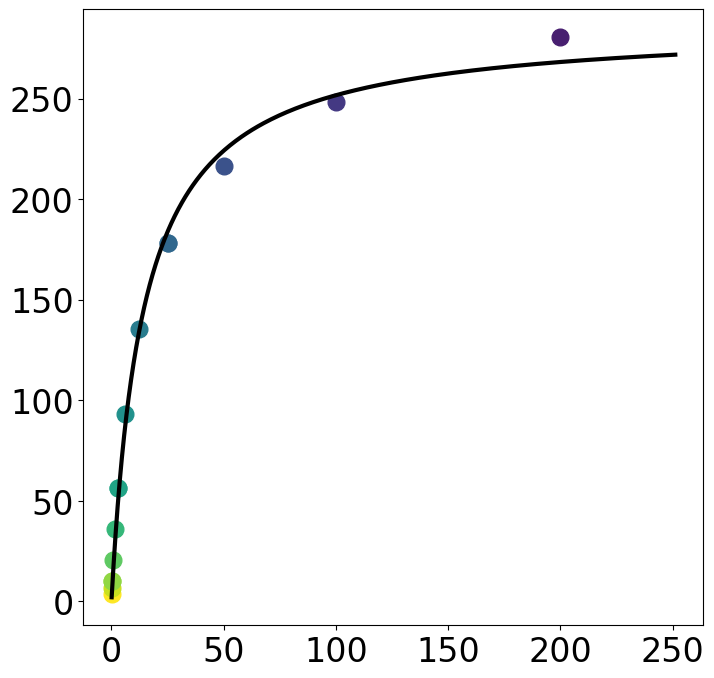

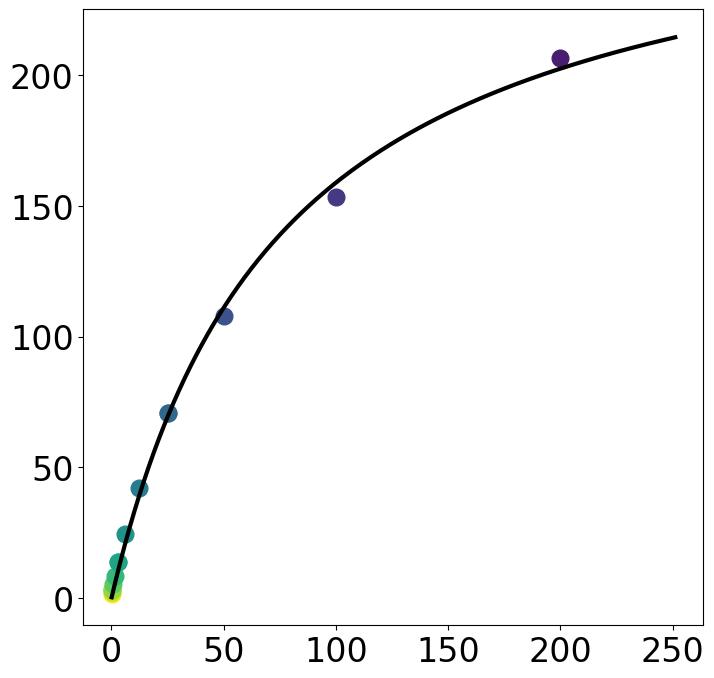

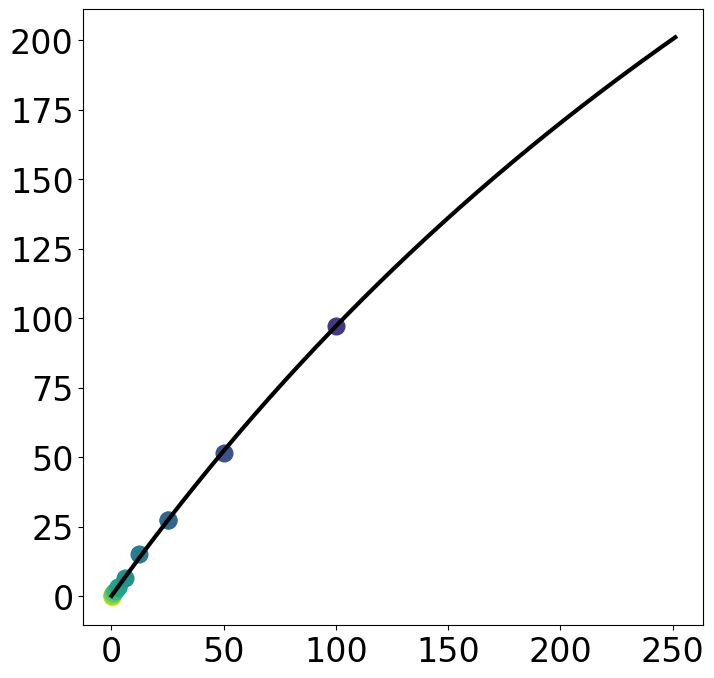

In [5]:
for pep in ['gp33','PF','Y4F']:
    
    plt.figure(figsize=[8,8])
    
    data_eq = pd.read_csv(glob(f'../figure2_H2Db-characterization-xtal/SPR raw data on smartMHC/202210 SPR wwDb/* wwDb {pep}.txt')[0],
                          sep='\t')
    data_eq = data_eq[~np.isnan(data_eq['X'])]

    params,cov = curve_fit(eqm_binding,data_eq["X"],data_eq["Y"],p0=[3e-5,300],bounds=[0,np.inf])
    
    x_fit = np.logspace(-7,-3.6,1000)
    y_fit = eqm_binding(x_fit,*params)
    
    print(pep, params*1e6, np.sqrt(cov)[[0,1],[0,1]]*1e6)

    for i,conc in enumerate(data_eq['X']):
        plt.plot(data_eq.loc[i,'X']*x_scale,data_eq.loc[i,'Y'],'o',color=colors[pep][round(conc*x_scale,2)],markersize=12)
    
    plt.plot(x_fit*x_scale,y_fit,'-',color='k',linewidth=3,label=pep)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.savefig(f'{pep}_TCR_binding_eqm.png',dpi=300,bbox_inches='tight')

In [17]:
sensogram.loc[1195:1215,:]

,Cycle: 18 gp33 Y4F 98 nM_X,Cycle: 18 gp33 Y4F 98 nM_Y,Cycle: 19 gp33 Y4F 195 nM_X,Cycle: 19 gp33 Y4F 195 nM_Y,Cycle: 20 gp33 Y4F 390 nM_X,Cycle: 20 gp33 Y4F 390 nM_Y,Cycle: 21 gp33 Y4F 390 nM_X,Cycle: 21 gp33 Y4F 390 nM_Y,Cycle: 22 gp33 Y4F 780 nM_X,Cycle: 22 gp33 Y4F 780 nM_Y,...,Cycle: 27 gp33 Y4F 12500 nM_X,Cycle: 27 gp33 Y4F 12500 nM_Y,Cycle: 28 gp33 Y4F 25000 nM_X,Cycle: 28 gp33 Y4F 25000 nM_Y,Cycle: 29 gp33 Y4F 25000 nM_X,Cycle: 29 gp33 Y4F 25000 nM_Y,Cycle: 30 gp33 Y4F 50000 nM_X,Cycle: 30 gp33 Y4F 50000 nM_Y,Cycle: 31 gp33 Y4F 100000 nM_X,Cycle: 31 gp33 Y4F 100000 nM_Y
1195,59.4401,-0.425583,59.54,-0.140218,59.4401,0.387558,59.5400,0.454941,59.4401,1.008830,...,59.5400,14.810100,59.4401,27.024500,59.54,26.979300,59.4401,50.735200,59.4401,95.953600
1196,59.5400,-0.385544,59.64,-0.176713,59.5400,0.391647,59.6400,0.460220,59.5400,1.011000,...,59.6400,14.791100,59.5400,27.023500,59.64,26.886900,59.5400,50.711500,59.5400,95.908500
1197,59.6400,-0.475968,59.74,0.080093,59.6401,0.327412,59.7401,0.436188,59.6400,0.980331,...,59.7401,14.698000,59.6400,27.052200,59.74,26.856600,59.6400,50.539400,59.6400,95.842300
1198,59.7401,-0.491028,59.84,0.171738,59.7401,0.455719,59.8400,0.482101,59.7401,1.161770,...,59.8400,14.656800,59.7401,27.017200,59.84,26.854500,59.7401,50.730300,59.7401,95.814000
1199,59.8400,-0.392776,59.94,0.679925,59.8400,0.307480,59.9400,0.716851,59.8400,1.215500,...,59.9400,14.938800,59.8400,26.866300,59.94,27.574800,59.8400,50.822300,59.8400,95.934100
1200,59.9401,-0.347275,60.04,-2.244960,59.9401,0.415482,60.0400,-0.478073,59.9401,1.778980,...,60.0400,27.356400,59.9401,28.027000,60.04,10.248300,59.9401,64.729100,59.9401,95.420200
1201,60.0400,-1.263470,60.14,2.888510,60.0400,0.175461,60.1400,2.450430,60.0400,-2.668870,...,60.1400,-9.201850,60.0400,20.917000,60.14,-7.557590,60.0400,-128.759000,60.0400,-140.057000
1202,60.1400,0.249779,60.24,1.485350,60.1401,1.112700,60.2401,1.844770,60.1400,4.976400,...,60.2401,78.061200,60.1400,-7.143930,60.24,140.543000,60.1400,185.653000,60.1400,-405.675000
1203,60.2401,-0.079697,60.34,0.622314,60.2401,2.065480,60.3400,1.124880,60.2401,6.949660,...,60.3400,64.814000,60.2401,136.564000,60.34,114.389000,60.2401,253.215000,60.2401,436.600000
1204,60.3400,-0.321472,60.44,0.118968,60.3400,1.412350,60.4400,0.585582,60.3400,4.721950,...,60.4400,41.713400,60.3400,111.974000,60.44,71.674400,60.3400,181.225000,60.3400,432.289000
